# Pokemon Diffusion
+ This is a baseline implementation for CL2 Lab in Imperial College London CSP MSc Lab


# Setup

### Downloading the Data and Creating necessary folder

In [1]:
# If we are on Colab, we need to get the data
import sys ,os
IN_COLAB = 'google.colab' in sys.modules
if IN_COLAB:
  print("Dataset is empty in Colab path. Cloning from GitHub...")
  !git clone https://github.com/gerritgr/pokemon_diffusion
  #!mkdir pokemon
  !cp -r pokemon_diffusion/pokemon pokemon/

elif not os.listdir("./pokemon_diffusion/pokemon/"): # in local environment, check the dataset in the path
  print("Dataset is empty in local path. Cloning from GitHub...")
  !git clone https://github.com/gerritgr/pokemon_diffusion
  #!mkdir pokemon
  !cp -r pokemon_diffusion/pokemon pokemon/
else:
  print("Dataset is ready!")

# Set the folder path as hhx_db_path using my unique name hhx to store imgs and params
hhx_db_path = "./imgs&params"
if not os.path.exists(hhx_db_path):
    os.makedirs(hhx_db_path)
    print("imgs&params folder created")

Dataset is ready!


### Imports

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 100 # Set this to 300 to get better image quality
from PIL import Image # We use PIL to load images
import seaborn as sns
import imageio # to generate .gifs

# always good to have
import glob, random, os
import numpy as np

# the typical pytorch imports
import torch
import torchvision
from torchvision import transforms 
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn
from torch.nn import Conv2d
from torch.optim import Adam

### Hyperparameters

These are just random hyperparameters, play around with them.

In [3]:
IMG_SIZE = 32   # We assume images are square with IMG_SIZE*IMG_SIZE pixels, 16x16 works, too.
EPOCHS = 5000
BATCH_SIZE = 32
TIMESTEPS = 100

# On Colab, go to Runtime -> Change runtime type to switch to GPU 
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CHANNELS = 3  # We use RGB images
DEVICE

device(type='cuda')

### Seeds
... to make everyting deterministic.

In [4]:
np.random.seed(42)
torch.random.manual_seed(42)
random.seed(42)
torch.cuda.manual_seed_all(42)
os.environ['PYTHONHASHSEED'] = '42'
torch.backends.cudnn.deterministic = True

### Utils

We start by defining some friendly little helpers. 

In [5]:
def image_to_tensor(image):
    """Convert a PIL image to a PyTorch tensor.

    Args:
        image (PIL.Image): The image to be converted.

    Returns:
        torch.Tensor: The converted PyTorch tensor.
    """
    # Define the image transformation pipeline
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.Lambda(lambda t: (t - 0.5) * 2.)
    ])

    # Apply the transformation pipeline to the image
    return transform(image)


def tensor_to_img(tensor):
    """Convert a PyTorch tensor to a PIL image.

    Args:
        tensor (torch.Tensor): The PyTorch tensor to be converted.

    Returns:
        PIL.Image: The converted PIL image.
    """
    # Define the tensor transformation pipeline
    transform = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1.) / 2.),
        transforms.Lambda(lambda t: torch.clamp(t, min=0., max=1.)),
        transforms.ToPILImage()
    ])

    # Apply the transformation pipeline to the tensor
    return transform(tensor)


def show_from_image_list(img_list, img_num=10, filename=None):
    """Show a grid of images from a list of images. Sample uniformly spaced images.
        (Alternativly, use make_grid from torchvision.utils)

    Args:
        img_list (list): The list of images to be displayed. Can be PIL or image tensors.
        img_num (int, optional): The number of images to be displayed. Default is 10.
        filename (str, optional): The name of the file to save the plot to. If None, the plot will not be saved. Default is None.
    """
    # Ensure that the number of images to be displayed is less than or equal to the number of images in the list
    img_num = min(len(img_list), img_num)

    # Get the index of the images to be displayed
    img_num_index = np.linspace(0, len(img_list)-1.0, num=img_num).astype(int)

    # Clear the current figure (if there is any)
    plt.clf()

    # Create a figure with 1 row and `img_num` columns
    fig, ax = plt.subplots(1, img_num, figsize=(15, 15), gridspec_kw={'width_ratios': [1] * img_num})

    # Iterate through the images to be displayed
    for i, idx in enumerate(img_num_index):
        img_i = img_list[idx]

        # Check if the image is a PyTorch tensor and convert it to PIL
        if isinstance(img_i, torch.Tensor):
            img_i = tensor_to_img(img_i)

        # Display the image
        ax[i].imshow(img_i)
        ax[i].axis('off')

    # Save the plot to a file if the filename is provided
    if filename is not None:
        plt.savefig(filename, dpi=300, bbox_inches='tight')

    # Show the plot
    plt.show()


# Defining the Dataset and Loader

First, we need to create a `Dataset` and a `DataLoader` containing the images (currently in the image folder). This is PyTorch best practice.

The `Dataset` provides access to individual data samples/images  (also providing on-the-fly image augmentation). The `Dataloader` enables efficient loading of the data in mini-batches (also providing randomization).

We build our own `Datset` class that loads the images from disk and stores them in PyTorch tensors of shape $(3, \text{IMG_SIZE}, \text{IMG_SIZE})$ with values between $-1$ and $1$.


In [6]:
from torch.utils.data import Dataset, DataLoader, IterableDataset, TensorDataset


class ImageDataset(Dataset):
  """A dataset for images that supports on-the-fly transformations (i.e., augmentations).

  Args:
      imgpaths (str, optional): The path pattern for the images. Default is "pokemon/*png".
  """

  def __init__(self, img_paths="./pokemon_diffusion/pokemon/*.png"):

    # You can/should play around with these. Which of the augmantation make sense? 
    self.on_the_fly_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5),
    transforms.RandomApply(torch.nn.ModuleList([transforms.RandomCrop(int(IMG_SIZE*0.8)),]), p=0.1),
    transforms.RandomAutocontrast(p=0.1),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.Lambda(lambda t: torch.clamp(t, min=-1., max=1.)),
    ])

    self.img_list = list()
    for img_path in glob.glob(img_paths):
      # Turn the transparent part in the image to white following 
      # https://stackoverflow.com/questions/50898034/how-replace-transparent-with-a-color-in-pillow
      image = Image.open(img_path)
      rgba_image = Image.new("RGBA", image.size, "WHITE")
      rgba_image.paste(image, (0, 0), image)   
      rgb_image = rgba_image.convert('RGB')

      # Convert the PIL image to a tensor, where each value is in [-1,1].
      img_as_tensor = image_to_tensor(rgb_image)
      self.img_list.append(img_as_tensor)

  def __getitem__(self, index):
    """Get an image tensor from the dataset with on-the-fly transformation.

    Args:
        index (int): The index of the image tensor in the dataset.

    Returns:
        torch.Tensor: The image tensor with on-the-fly transformation.
    """
    img = self.img_list[index]
    img = self.on_the_fly_transform(img)

    return img
  
  def get_pil_image(self, index, with_random_augmentation=True):
    """Get a PIL image from the dataset with or without on-the-fly transformation.

    Args:
        index (int): The index of the PIL image in the dataset.
        with_random_augmentation (bool, optional): Whether to apply on-the-fly transformation. Default is True.

    Returns:
        PIL.Image: The PIL image with or without on-the-fly transformation.
    """
    if with_random_augmentation:
      return tensor_to_img(self.__getitem__(index))
    return tensor_to_img(self.img_list[index])

  def __len__(self):
    return len(self.img_list)


dataset = ImageDataset()

dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [7]:
# Note hat just grabbing an image from the dataset adds a random image augmentation.
# Generally speaking, this will be False. Try a few times.
torch.all(dataset[0] == dataset[0])  # torch.all test if all entries are True

tensor(True)

### Inspecting the Dataset

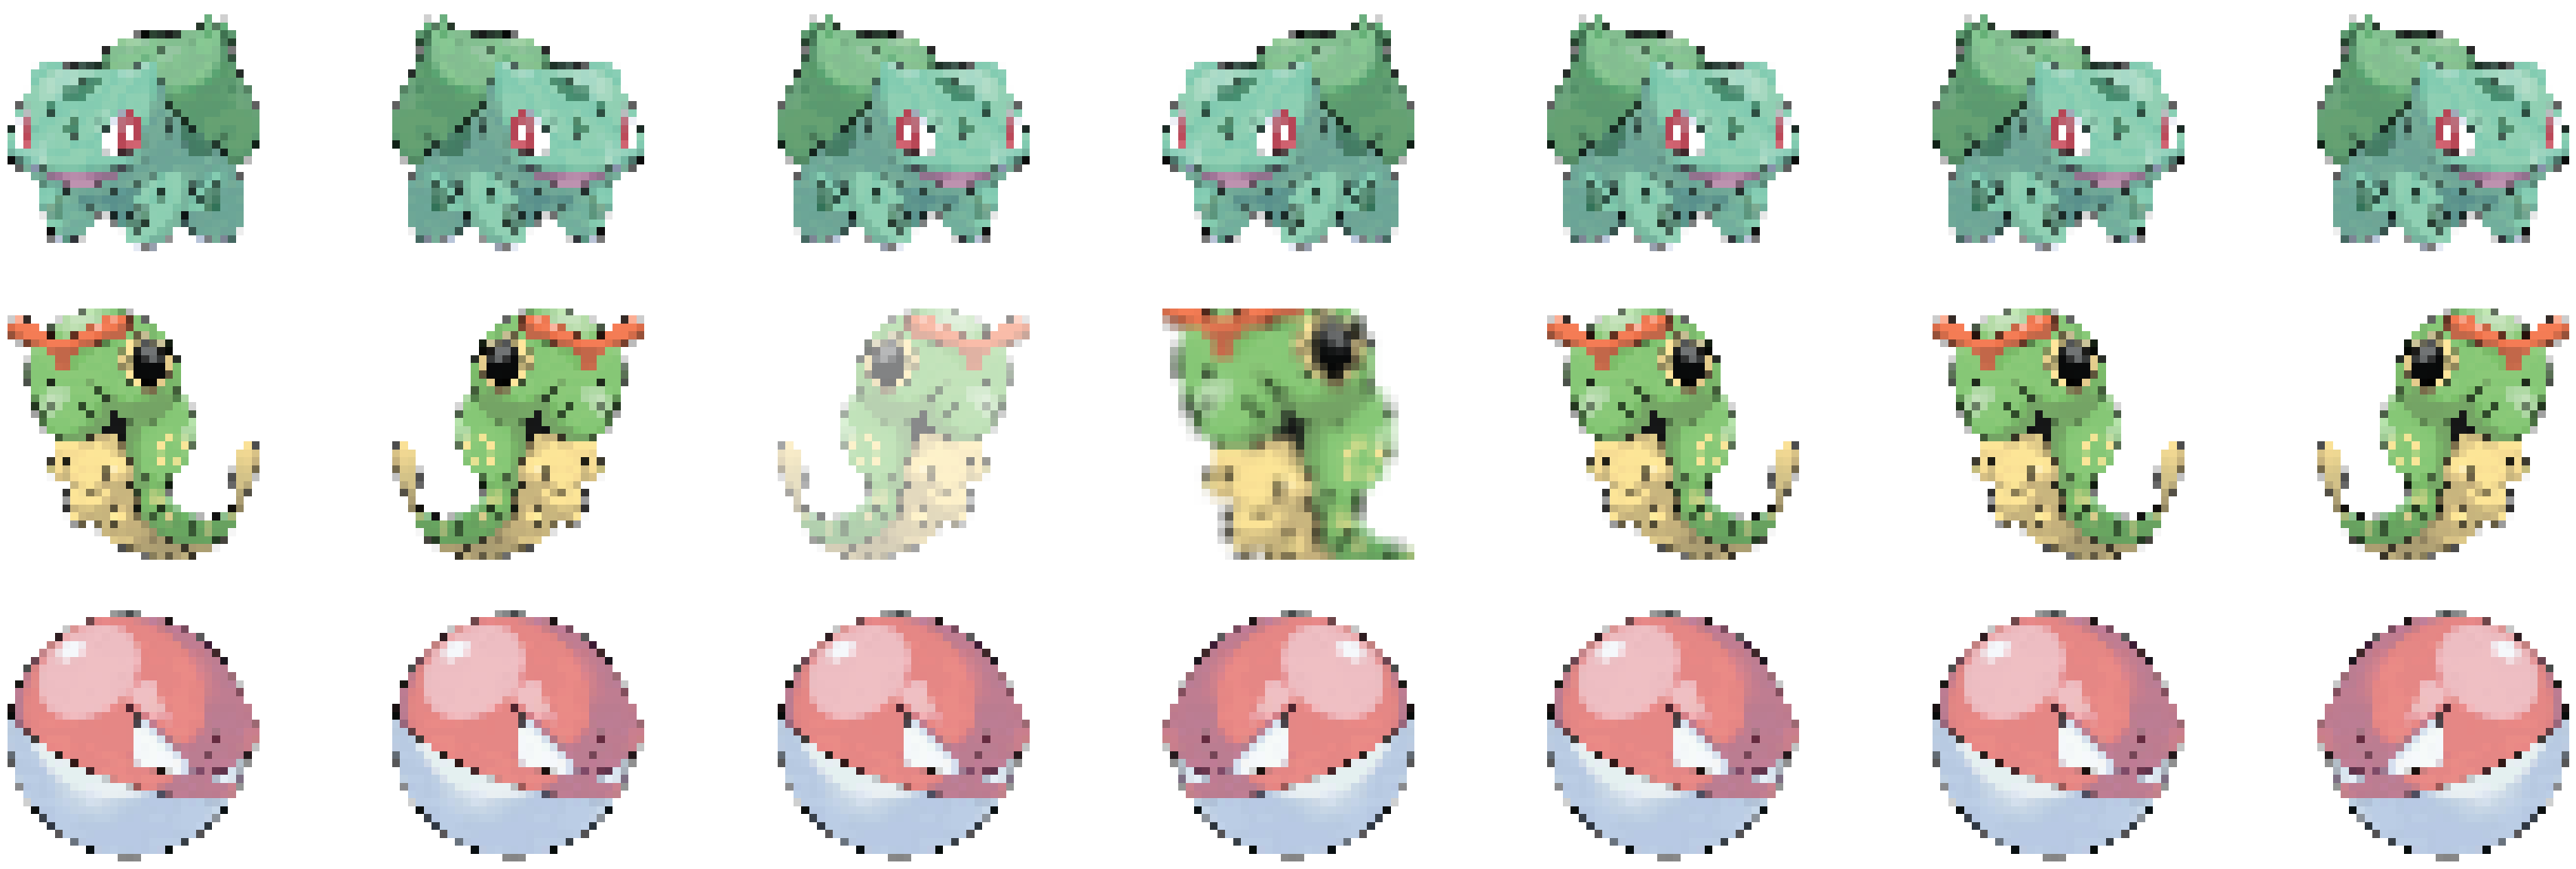

In [8]:
# Visualize the data

# Show seven versions of the first three Pokemons. 
images_per_row = 7
fig, axes = plt.subplots(3, images_per_row, figsize=(45, 15))

# Plotting each image in a subplot
for i, ax in enumerate(axes.flat):
    # The leftmost Pokemon is without augmentation (with_random_augmentation is False).
    with_random_augmentation = False if i % images_per_row == 0 else True
    ax.imshow(dataset.get_pil_image(i//images_per_row, with_random_augmentation=with_random_augmentation))
    ax.axis('off')

plt.savefig(os.path.join(hhx_db_path, 'dataset_summary.png'), bbox_inches='tight')
plt.show()


Next, we visualize the frequency of each RGB value in the image dataset (before augmentation). After the forward process, this should look like three standard normal distributions.

In [9]:
# Create giant tensor with all images.
img_num = len(dataset.img_list)
tensor_with_all_images = torch.zeros((img_num, CHANNELS, IMG_SIZE, IMG_SIZE))
for i, img in enumerate(dataset.img_list):
  tensor_with_all_images[i,:,:,:] = img

# Save the pixel values of all images in 1D tensor for each channel. 
pixels_red = tensor_with_all_images[:,0,:,:].flatten().numpy()
pixels_green = tensor_with_all_images[:,1,:,:].flatten().numpy()
pixels_blue = tensor_with_all_images[:,2,:,:].flatten().numpy()

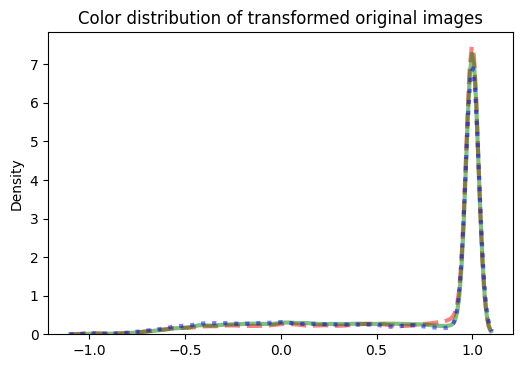

In [10]:
ax = sns.kdeplot(pixels_red, color="red", alpha=0.5, ls="--", lw=3)
sns.kdeplot(pixels_green, color="green", ax=ax, alpha=0.5, lw=3)
sns.kdeplot(pixels_blue, color="blue", ax=ax, alpha=0.5, ls=":", lw=3)
plt.title("Color distribution of transformed original images")
plt.savefig(os.path.join(hhx_db_path,'color_distribution_original_images.png'), dpi=300, bbox_inches='tight')

# Visualizing the Forward Process

<Figure size 600x400 with 0 Axes>

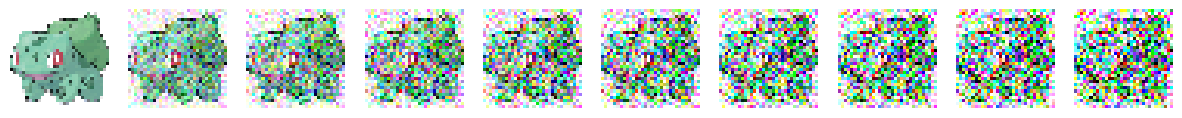

In [11]:
def one_step_forward(img, t):
  #
  # This is not correct!!! Fix it.
  #
  return img + torch.randn_like(img, device=DEVICE)*0.1

def create_forward_animation(dataset):
  img = dataset.img_list[0].to(DEVICE)
  img_list = list()
  # if TIMESTEPS is too large, you can use a subset
  img_list.append(tensor_to_img(img)) 
  for t in range(TIMESTEPS):
    img = one_step_forward(img, t=t)
    img_list.append(tensor_to_img(img)) 
  return img_list
  
img_list = create_forward_animation(dataset)

# the .gif file can get pretty large
imageio.mimsave(os.path.join(hhx_db_path,"forward_animate.gif"), img_list, fps=10) 
# we can also show the images inline
show_from_image_list(img_list, filename = 'forward_grid.png')


# ====== Solution ======

## 1. Setting up
### 1.1 Hyperparameters 

In [12]:
# new hyperparams
TIMESTEPS = 1000
beta_0 = 0.0001
beta_T = 0.02
LEARNING_RATE = 0.001
# generate alphas,betas,alpha_bars using my unique name hhx to store
hhx_betas = torch.linspace(beta_0, beta_T, TIMESTEPS, device = DEVICE)
hhx_alphas = 1.0 - hhx_betas
hhx_alpha_bars = torch.cumprod(hhx_alphas, axis=0)

### Util

In [13]:
def gif_player(gif_path):
    """
    Display a GIF in a Jupyter notebook.
    
    This function reads a GIF from the provided path, encodes it in base64, 
    and then displays it in a Jupyter notebook. 

    Args:
    - gif_path (str): The path to the GIF file.
    """
    # impott relevant package
    import base64
    from IPython.display import display, HTML

    # Load gif
    with open(gif_path , 'rb') as f:
        gif = f.read()

    # Convert the gif to a base64 encoded string
    encoded_gif = base64.b64encode(gif).decode('utf-8')

    # Display the gif in the notebook
    display(HTML(f'<div style="text-align: center;"><img src="data:image/gif;base64,{encoded_gif}" width="100px height=100px"/></div>'))

def random_number_from_string(input_string, min_value, max_value):
    """
    Generate a random number based on a given string.
    
    The string is converted to a deterministic seed using a hash function.
    This ensures that the same input string will always produce the 
    same random number, given the same min and max bounds.
    
    Args:
    - input_string (str): The input string.
    - min_value (int): The lower bound for the random number. Defaults to 0.
    - max_value (int): The upper bound for the random number. Defaults to 100.
    
    Returns:
    - int: A random number between min_value and max_value.
    """
    import hashlib
    import random
    # Convert the string to a deterministic seed using hashlib
    seed = int(hashlib.md5(input_string.encode()).hexdigest(), 16)
    
    # Seed the random number generator
    random.seed(seed)
    
    # Return the random number
    return random.randint(min_value, max_value)

def standard_normal_pdf(x):
    import math
    """
    Compute the probability density function (PDF) of the standard normal distribution for a given x.
    
    Args:
    - x (float): The value for which the PDF is to be computed.
    
    Returns:
    - float: The PDF value of the standard normal distribution at x.
    """
    return (1 / math.sqrt(2 * math.pi)) * math.exp(-0.5 * x**2)

def extract(source, positions, out_shape):
    """
    Extract values from tensor 'source' at positions specified by tensor 'positions'.

    Args:
    - source (torch.Tensor): The source tensor from which values are to be extracted.
                        Expected shape is (batch_size, feature_dim, ...).
    - positions (torch.Tensor): The tensor specifying positions for each item in the batch.
                        Expected shape is (batch_size,).
    - out_shape (tuple): Shape of another tensor, typically an input tensor. 
                       Used to ensure the output has the same number of dimensions.

    Returns:
    - torch.Tensor: A tensor containing the values extracted from 'source' 
                    at positions specified by 'positions'. The shape is (batch_size, 1, ...),
                    with the number of dimensions matching 'out_shape'.
    """
    # Get the batch size from tensor 'positions'
    batch_size, *_ = positions.shape

    # Use the 'gather' method to extract values from 'source' based on 'positions'
    out = source.gather(-1, positions)

    # Reshape the output tensor to match the target dimensions
    return out.reshape(batch_size, *((1,) * (len(out_shape) - 1)))

def correct_dims(x):
    """
    Checks the shape of a given tensor and adds batch dimension if necessary.
    
    Args:
    x (torch.Tensor): The input tensor.

    Returns:
    torch.Tensor: The output tensor with corrected shape: (batch_dim, CHANNELS, IMG_SIZE, IMG_SIZE)
    """
    if x.dim() == 2:
        assert(False)
    elif x.dim() == 3:
        batch_dim = 1
        x = x.reshape(batch_dim, CHANNELS, IMG_SIZE, IMG_SIZE)
    elif x.dim() == 4:
        return x
    else:
        assert(False)
    return x




## 2. Forward Process
### 2.1 Fix one step forward and animation functions

hhx_orward_grid_correct.png:


<Figure size 600x400 with 0 Axes>

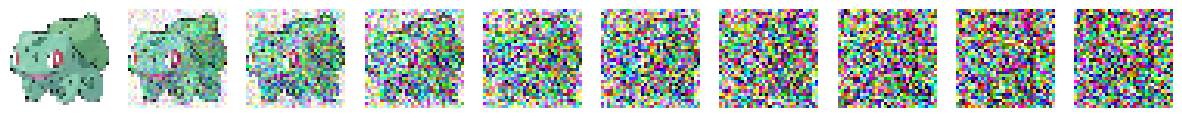

hhx_forward_animate_correct.gif:



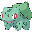

In [14]:
def fixed_one_step_forward(xt_minus_1, t):
    """
    fixed one step of a forward process according to one step formula in DDPM paper[https://arxiv.org/abs/2006.11239].
    
    Args:
    xt_minus_1(torch.Tensor): The input image tensor in t-1 step (previous image).
    t (int): The current time step.

    Returns:
    xt (torch.Tensor): The output image tensor in t step after one step of the forward process.
    """
    
    noise = torch.randn_like(xt_minus_1, device = DEVICE)
    beta_t = hhx_betas[t]
    xt= torch.sqrt(1.0 - beta_t) * xt_minus_1 + torch.sqrt(beta_t) * noise

    return xt

def fixed_forward_animation(dataset):
    """
    fixed the animation of the forward diffusion function in previous code block.

    Args:
    - dataset (Dataset): The dataset containing images to be processed.

    Returns:
    - list: A sequence of PIL images representing the animation frames.
    """
    img = dataset.img_list[0].to(DEVICE)
    img_list = []

    # Append the initial image to the list
    img_list.append(tensor_to_img(img)) 

    # Process the image using the forward diffusion process over specified timesteps
    for t in range(TIMESTEPS):
        img = fixed_one_step_forward(img, t=t)
        img_list.append(tensor_to_img(img)) 

    return img_list

img_list = fixed_forward_animation(dataset)
# save the .gif file and using my unique name hhx to store
imageio.mimsave(os.path.join(hhx_db_path,"hhx_forward_animate_correct.gif"), img_list, fps=30) 
# we can also show the png and gif images inline
print("hhx_orward_grid_correct.png:")
show_from_image_list(img_list, filename = os.path.join(hhx_db_path,"hhx_orward_grid_correct.png"))
print("hhx_forward_animate_correct.gif:")
gif_player(os.path.join(hhx_db_path,"hhx_forward_animate_correct.gif"))

### 2.2 Diffusion forward process q(t)

perform 250 steps,we obtain x_250:


<Figure size 600x400 with 0 Axes>

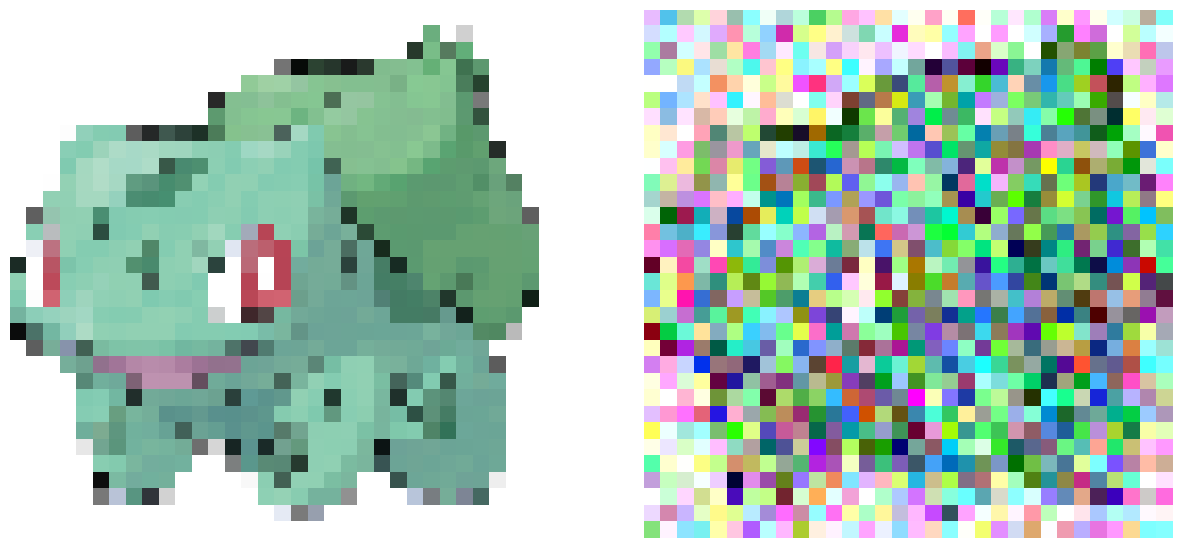

In [15]:
def hhx_forward_diffusion(x_0, t):
    """
    Perform the forward diffusion process based on the given input clean image x_0 and timestep t.
    This function computes x[t] based on x[0], using the diffusion process defined in the DDPM paper[https://arxiv.org/abs/2006.11239]. 
    
    Args:
    - x_0 (torch.Tensor): The input clean image tensor. Expected to be a 4D tensor of shape 
                          (batch_size, Channels, Img_size, Img_size).
    - t (torch.Tensor): The timestep tensor.
    
    Returns:
    - torch.Tensor: The tensor x[t] after the diffusion process.
    - torch.Tensor: The noise tensor generated during the process.
    """
    # Generate a sample from the normal distribution
    noise = torch.randn_like(x_0)    
    # must be 4 dim batch_size X Channels X Img_size X Img_size
    if not x_0.dim() == 4:
        assert(False)
    # Get the mean and variance. Choose sqrt_alphas_bar_t and sqrt_one_minus_alphas_bar 
    # values based on the timestep.
    sqrt_alphas_bar_t = torch.sqrt(torch.gather(hhx_alpha_bars, 0, t))
    sqrt_one_minus_alphas_bar = torch.sqrt(1-torch.gather(hhx_alpha_bars, 0, t))
    batch_dim = x_0.size(0)
    
    # Compute x[t] based on x[0]
    x_t = sqrt_alphas_bar_t.view((batch_dim,1,1,1)) * x_0 + \
                sqrt_one_minus_alphas_bar.view(batch_dim,1,1,1) * noise
    
    return x_t ,noise
# reshape as 4 dim batch_size X Channels X Img_size X Img_size
x0 = dataset.img_list[0].to(DEVICE).reshape(1, CHANNELS, IMG_SIZE, IMG_SIZE) 
#generate unique random number from my name
random_number = random_number_from_string("Haoxiang Huang",1,10)
t = torch.tensor([TIMESTEPS //random_number], device=DEVICE)
print("perform %d steps,we obtain x_%d:"%(t.item(),t.item()))
xt, noise = hhx_forward_diffusion(x0, t)
xt_img = tensor_to_img(xt.squeeze())
x0_img = tensor_to_img(x0.squeeze())

show_from_image_list([x0_img, xt_img])


### 2.3 Visualize Forward RGB
Next, we visualize the frequency of each RGB value after the forward process, this should look like three standard normal distributions. 

==This block is modified based on the provided code block of dataset RGB visualiztion above==

Processing a total of 919 images in the dataset.


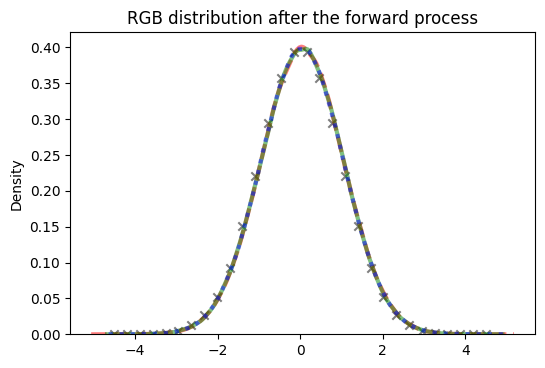

In [16]:
img_num = len(dataset.img_list) # obtain a total of image sizes in the dataset
print("Processing a total of %d images in the dataset."%img_num)
tensor_with_all_images = torch.zeros((img_num, CHANNELS, IMG_SIZE, IMG_SIZE))
tensor_with_all_images.to(DEVICE)
for i in range(img_num):
  x0 = dataset.img_list[i].to(DEVICE)
  x0 = x0.reshape(1, CHANNELS, IMG_SIZE, IMG_SIZE) # add batch size dim
  # Warning: The maximum value of 't' should be 'TIMESTEPS-1'. 
  # Exceeding this will result in indexing out of bounds in alphas etc.
  t = torch.tensor([TIMESTEPS-1], device=DEVICE) 
  #print("perform %d steps,we obtain x_%d"%(t.item(),t.item()))
  xt, noise = hhx_forward_diffusion(x0, t)
  tensor_with_all_images[i,:,:,:] = xt

# Save the pixel values of all images in 1D tensor for each channel. 
pixels_red = tensor_with_all_images[:,0,:,:].flatten().numpy()
pixels_green = tensor_with_all_images[:,1,:,:].flatten().numpy()
pixels_blue = tensor_with_all_images[:,2,:,:].flatten().numpy()

# Clear the current figure
plt.clf()

# Create a set of x-values for the Gaussian reference
x_values = np.linspace(-4.5, 4.5, 30)

# Plot the Gaussian reference
plt.scatter(x_values, [standard_normal_pdf(x) for x in x_values], 
            c='black', alpha=0.5, marker='x', edgecolors=None, label='Gaussian')

# Plot for RGB channels referring to the provided previous code block.
ax = sns.kdeplot(pixels_red, color="red", alpha=0.5, ls="--", lw=3)
sns.kdeplot(pixels_green, color="green", ax=ax, alpha=0.5, lw=3)
sns.kdeplot(pixels_blue, color="blue", ax=ax, alpha=0.5, ls=":", lw=3)

# Add title and save the plot
plt.title("RGB distribution after the forward process")
plt.savefig(os.path.join(hhx_db_path, 'color_distribution_original_images.png'), dpi=300, bbox_inches='tight')

## 3. Diffusion Backward Noise Predict Model
Based on the official Tensorflow repository [https://github.com/hojonathanho/diffusion] for DDPM [https://arxiv.org/abs/2006.11239], this was implemented using PyTorch coding style.

In [17]:
from inspect import isfunction
from functools import partial
from einops import rearrange
from torch import nn, einsum
import math



def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class My_Unet(nn.Module):
    def __init__(
        self,
        dim=IMG_SIZE,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=CHANNELS,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = correct_dims(x)
        img_withnoise = x*1.0
        img_shape = img_withnoise.shape

        
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = self.final_conv(x)
        x = img_withnoise-x # here x is the img wo noise
        return x.squeeze()

timestep = torch.randn(1, device = DEVICE)

model = My_Unet(
    dim=IMG_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4,)
).to(DEVICE)
img = torch.randn([1, 3, IMG_SIZE, IMG_SIZE]).to(DEVICE)
out = model(img, timestep)
out.shape


torch.Size([3, 32, 32])

In [18]:
from inspect import isfunction
from functools import partial
from einops import rearrange
from torch import nn, einsum
import math



def exists(x):
    return x is not None

def default(val, d):
    if exists(val):
        return val
    return d() if isfunction(d) else d

class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x, *args, **kwargs):
        return self.fn(x, *args, **kwargs) + x

def Upsample(dim):
    return nn.ConvTranspose2d(dim, dim, 4, 2, 1)

def Downsample(dim):
    return nn.Conv2d(dim, dim, 4, 2, 1)


class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class Block(nn.Module):
    def __init__(self, dim, dim_out, groups = 8):
        super().__init__()
        self.proj = nn.Conv2d(dim, dim_out, 3, padding = 1)
        self.norm = nn.GroupNorm(groups, dim_out)
        self.act = nn.SiLU()

    def forward(self, x, scale_shift = None):
        x = self.proj(x)
        x = self.norm(x)

        if exists(scale_shift):
            scale, shift = scale_shift
            x = x * (scale + 1) + shift

        x = self.act(x)
        return x

class ResnetBlock(nn.Module):
    """https://arxiv.org/abs/1512.03385"""
    
    def __init__(self, dim, dim_out, *, time_emb_dim=None, groups=8):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.SiLU(), nn.Linear(time_emb_dim, dim_out))
            if exists(time_emb_dim)
            else None
        )

        self.block1 = Block(dim, dim_out, groups=groups)
        self.block2 = Block(dim_out, dim_out, groups=groups)
        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.block1(x)

        if exists(self.mlp) and exists(time_emb):
            time_emb = self.mlp(time_emb)
            h = rearrange(time_emb, "b c -> b c 1 1") + h

        h = self.block2(h)
        return h + self.res_conv(x)
    
class ConvNextBlock(nn.Module):
    """https://arxiv.org/abs/2201.03545"""

    def __init__(self, dim, dim_out, *, time_emb_dim=None, mult=2, norm=True):
        super().__init__()
        self.mlp = (
            nn.Sequential(nn.GELU(), nn.Linear(time_emb_dim, dim))
            if exists(time_emb_dim)
            else None
        )

        self.ds_conv = nn.Conv2d(dim, dim, 7, padding=3, groups=dim)

        self.net = nn.Sequential(
            nn.GroupNorm(1, dim) if norm else nn.Identity(),
            nn.Conv2d(dim, dim_out * mult, 3, padding=1),
            nn.GELU(),
            nn.GroupNorm(1, dim_out * mult),
            nn.Conv2d(dim_out * mult, dim_out, 3, padding=1),
        )

        self.res_conv = nn.Conv2d(dim, dim_out, 1) if dim != dim_out else nn.Identity()

    def forward(self, x, time_emb=None):
        h = self.ds_conv(x)

        if exists(self.mlp) and exists(time_emb):
            assert exists(time_emb), "time embedding must be passed in"
            condition = self.mlp(time_emb)
            h = h + rearrange(condition, "b c -> b c 1 1")

        h = self.net(h)
        return h + self.res_conv(x)

class Attention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)
        self.to_out = nn.Conv2d(hidden_dim, dim, 1)

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )
        q = q * self.scale

        sim = einsum("b h d i, b h d j -> b h i j", q, k)
        sim = sim - sim.amax(dim=-1, keepdim=True).detach()
        attn = sim.softmax(dim=-1)

        out = einsum("b h i j, b h d j -> b h i d", attn, v)
        out = rearrange(out, "b h (x y) d -> b (h d) x y", x=h, y=w)
        return self.to_out(out)

class LinearAttention(nn.Module):
    def __init__(self, dim, heads=4, dim_head=32):
        super().__init__()
        self.scale = dim_head**-0.5
        self.heads = heads
        hidden_dim = dim_head * heads
        self.to_qkv = nn.Conv2d(dim, hidden_dim * 3, 1, bias=False)

        self.to_out = nn.Sequential(nn.Conv2d(hidden_dim, dim, 1), 
                                    nn.GroupNorm(1, dim))

    def forward(self, x):
        b, c, h, w = x.shape
        qkv = self.to_qkv(x).chunk(3, dim=1)
        q, k, v = map(
            lambda t: rearrange(t, "b (h c) x y -> b h c (x y)", h=self.heads), qkv
        )

        q = q.softmax(dim=-2)
        k = k.softmax(dim=-1)

        q = q * self.scale
        context = torch.einsum("b h d n, b h e n -> b h d e", k, v)

        out = torch.einsum("b h d e, b h d n -> b h e n", context, q)
        out = rearrange(out, "b h c (x y) -> b (h c) x y", h=self.heads, x=h, y=w)
        return self.to_out(out)


class PreNorm(nn.Module):
    def __init__(self, dim, fn):
        super().__init__()
        self.fn = fn
        self.norm = nn.GroupNorm(1, dim)

    def forward(self, x):
        x = self.norm(x)
        return self.fn(x)

class example_Unet(nn.Module):
    def __init__(
        self,
        dim=IMG_SIZE,
        init_dim=None,
        out_dim=None,
        dim_mults=(1, 2, 4, 8),
        channels=CHANNELS,
        with_time_emb=True,
        resnet_block_groups=8,
        use_convnext=True,
        convnext_mult=2,
    ):
        super().__init__()

        # determine dimensions
        self.channels = channels

        init_dim = default(init_dim, dim // 3 * 2)
        self.init_conv = nn.Conv2d(channels, init_dim, 7, padding=3)

        dims = [init_dim, *map(lambda m: dim * m, dim_mults)]
        in_out = list(zip(dims[:-1], dims[1:]))
        
        if use_convnext:
            block_klass = partial(ConvNextBlock, mult=convnext_mult)
        else:
            block_klass = partial(ResnetBlock, groups=resnet_block_groups)

        # time embeddings
        if with_time_emb:
            time_dim = dim * 4
            self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(dim),
                nn.Linear(dim, time_dim),
                nn.GELU(),
                nn.Linear(time_dim, time_dim),
            )
        else:
            time_dim = None
            self.time_mlp = None

        # layers
        self.downs = nn.ModuleList([])
        self.ups = nn.ModuleList([])
        num_resolutions = len(in_out)

        for ind, (dim_in, dim_out) in enumerate(in_out):
            is_last = ind >= (num_resolutions - 1)

            self.downs.append(
                nn.ModuleList(
                    [
                        block_klass(dim_in, dim_out, time_emb_dim=time_dim),
                        block_klass(dim_out, dim_out, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_out, LinearAttention(dim_out))),
                        Downsample(dim_out) if not is_last else nn.Identity(),
                    ]
                )
            )

        mid_dim = dims[-1]
        self.mid_block1 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)
        self.mid_attn = Residual(PreNorm(mid_dim, Attention(mid_dim)))
        self.mid_block2 = block_klass(mid_dim, mid_dim, time_emb_dim=time_dim)

        for ind, (dim_in, dim_out) in enumerate(reversed(in_out[1:])):
            is_last = ind >= (num_resolutions - 1)

            self.ups.append(
                nn.ModuleList(
                    [
                        block_klass(dim_out * 2, dim_in, time_emb_dim=time_dim),
                        block_klass(dim_in, dim_in, time_emb_dim=time_dim),
                        Residual(PreNorm(dim_in, LinearAttention(dim_in))),
                        Upsample(dim_in) if not is_last else nn.Identity(),
                    ]
                )
            )

        out_dim = default(out_dim, channels)
        self.final_conv = nn.Sequential(
            block_klass(dim, dim), nn.Conv2d(dim, out_dim, 1)
        )

    def forward(self, x, time):
        x = correct_dims(x)
        img_withnoise = x*1.0
        img_shape = img_withnoise.shape

        
        x = self.init_conv(x)

        t = self.time_mlp(time) if exists(self.time_mlp) else None

        h = []

        # downsample
        for block1, block2, attn, downsample in self.downs:
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            h.append(x)
            x = downsample(x)

        # bottleneck
        x = self.mid_block1(x, t)
        x = self.mid_attn(x)
        x = self.mid_block2(x, t)

        # upsample
        for block1, block2, attn, upsample in self.ups:
            x = torch.cat((x, h.pop()), dim=1)
            x = block1(x, t)
            x = block2(x, t)
            x = attn(x)
            x = upsample(x)

        x = self.final_conv(x)
        x = img_withnoise-x # here x is the img wo noise
        return x.squeeze()

timestep = torch.randn(1, device = DEVICE)

model = example_Unet(
    dim=IMG_SIZE,
    channels=CHANNELS,
    dim_mults=(1, 2, 4,)
).to(DEVICE)
img = torch.randn([1, 3, IMG_SIZE, IMG_SIZE]).to(DEVICE)
out = model(img, timestep)
out.shape


torch.Size([3, 32, 32])

In [19]:
def denoise_one_step_sample(model, x, timestep):
    beta_t = hhx_betas[timestep]
    alpha_t = hhx_alphas[timestep]
    alpha_bar_t = hhx_alpha_bars[timestep]
    sqrt_one_minus_alpha_bar_t = torch.sqrt(1-alpha_bar_t)
    sqrt_recip_alphas_t = torch.sqrt(1.0 / alpha_t)
   
    timestep_tensor = torch.tensor([timestep], device=DEVICE)
    model_mean = sqrt_recip_alphas_t * (
        x - beta_t * model(x,  timestep_tensor) / sqrt_one_minus_alpha_bar_t)
    
    alpha_bar_prev = F.pad(hhx_alpha_bars[:-1], (1, 0), value=1.0)

    # calculations for posterior q(x_{t-1} | x_t, x_0)
    posterior_variance = hhx_betas * (1. - alpha_bar_prev) / (1. - hhx_alpha_bars)

    if timestep == 0:
        return model_mean
    else:
        posterior_variance_t = posterior_variance[timestep]
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def hhx_denoising_process(model, epoch):
    plt.clf()
    img = torch.randn(CHANNELS, IMG_SIZE, IMG_SIZE, device = DEVICE)
    img_num = 11
    img_num_index = np.linspace(0,TIMESTEPS, num=img_num-1)
    img_num_index = [int(x+0.5) for x in img_num_index]
    fig, ax = plt.subplots(1, img_num, figsize=(15,15), gridspec_kw={'width_ratios': [1]*img_num})
    ax_index = img_num-1
    denoise_out = img
    ax[ax_index].imshow(tensor_to_img(denoise_out))
    ax[ax_index].axis('off')
    ax_index -= 1
    for time_step in reversed(range(len(hhx_betas))):
        denoise_out = denoise_one_step_sample(model, denoise_out, time_step)
        denoise_out = torch.clamp(denoise_out, min=-4.0, max=4.0)
        if time_step <= img_num_index[-1]:
            img_num_index.pop()         
            ax[ax_index].imshow(tensor_to_img(denoise_out))
            ax[ax_index].axis('off')
            ax_index -= 1

    plt.savefig(os.path.join(hhx_db_path,"reverse_process_reference_epoch_{str(epoch).zfill(6)}.png"), dpi=300, bbox_inches='tight')
    plt.show()

    return None

#### Train

In [20]:
def train_epoch(model, dataloader, optimizer):
    loss_list = list()
    for x in dataloader:
        x= x.to(DEVICE)
        batch_size = x.shape[0]
        optimizer.zero_grad()
        t = torch.randint(0, TIMESTEPS - 1, (batch_size,), device = DEVICE)
        x_t, noise = hhx_forward_diffusion(x, t)
        noise_pred = model(x_t, t)
        noise = noise.squeeze()
        # print("noise")
        # print(noise.shape)
        # print("noise_pred")
        # print(noise_pred.shape)
        loss = F.mse_loss(noise_pred, noise)
        loss.backward()
        loss_list.append(loss.item())
        optimizer.step()

    return np.mean(loss_list)